In [2]:
import torch
import os, json, math
from pathlib import Path
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


## Hessians stats

In [ ]:
BASE_DIR = "./setup1" 
LRS_TO_USE = ["0.1", "0.01" , "0.001"] #,  "0.0001"]  # "0.01" или "0.1"
W_SGD =[]
for LR_TO_USE in LRS_TO_USE:
    PATH = os.path.join(BASE_DIR, f"sgd_weights_lr{LR_TO_USE}.pt")  # ожидаем shape [N, T, D]
    W_SGD.append(torch.load(PATH, map_location="cpu").detach())
W_SGD[0].shape


FileNotFoundError: [Errno 2] No such file or directory: './setup2/sgd_weights_lr0.001.pt'

In [ ]:
BASE_DIR = "./setup2"
RS_TO_USE = ["0.1", "0.01" , "0.001"] #,  "0.0001"] 
W_GD = []
for LR_TO_USE in LRS_TO_USE:
    PATH = os.path.join(BASE_DIR, f"gd_weights_lr{LR_TO_USE}_dtypedouble.pt")
    W_GD.append(torch.load(PATH, map_location="cpu"))
print(W_GD[0].shape)


FileNotFoundError: [Errno 2] No such file or directory: './setup1/gd_weights_lr0.1_dtypedouble.pt'

In [88]:
# plt.plot(W_SGD[0].mean(axis=0)[:, 0])
# plt.plot(W_SGD[1].mean(axis=0)[:, 0])
# plt.plot(W_GD[0][:,0])
# plt.plot(W_GD[1][:,0])

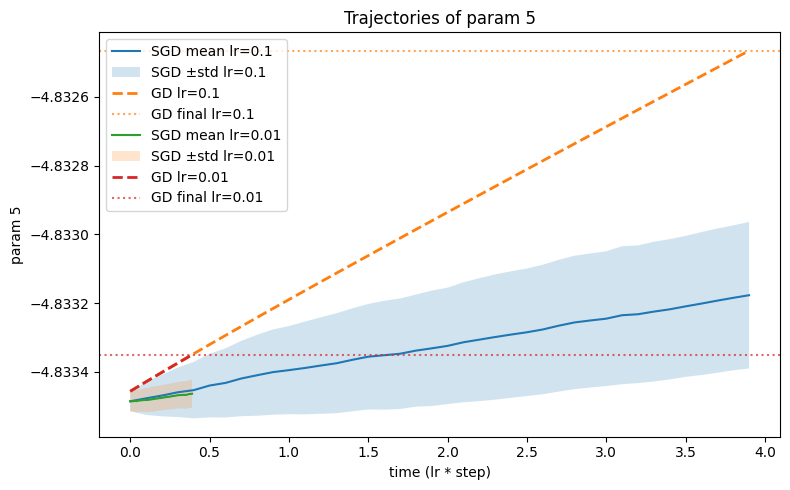

In [111]:
p = 5  # индекс параметра
plt.figure(figsize=(8, 5))

for i, lr in enumerate([float(x) for x in LRS_TO_USE]):
    # SGD: [N, T, D]
    trajs = W_SGD[i][:, :, p].numpy()[:,:40]  # shape [N, T]
    mean_traj = trajs.mean(axis=0)
    std_traj = trajs.std(axis=0)

    t_sgd = lr * np.arange(trajs.shape[1])

    plt.plot(t_sgd, mean_traj, label=f"SGD mean lr={lr}")
    plt.fill_between(t_sgd,
                     mean_traj - std_traj,
                     mean_traj + std_traj,
                     alpha=0.2, label=f"SGD ±std lr={lr}")

    # GD: [T, D]
    traj_gd = W_GD[i][:, p].numpy()[:40]
    t_gd = lr * np.arange(len(traj_gd))

    plt.plot(t_gd, traj_gd, '--', linewidth=2, label=f"GD lr={lr}")

    # горизонтальная линия по финальной точке GD
    final_val = traj_gd[-1]
    plt.axhline(final_val, linestyle=":", color=plt.gca().lines[-1].get_color(),
                alpha=0.7, label=f"GD final lr={lr}")

plt.xlabel("time (lr * step)")
plt.ylabel(f"param {p}")
plt.title(f"Trajectories of param {p}")
plt.legend()
plt.tight_layout()
plt.show()

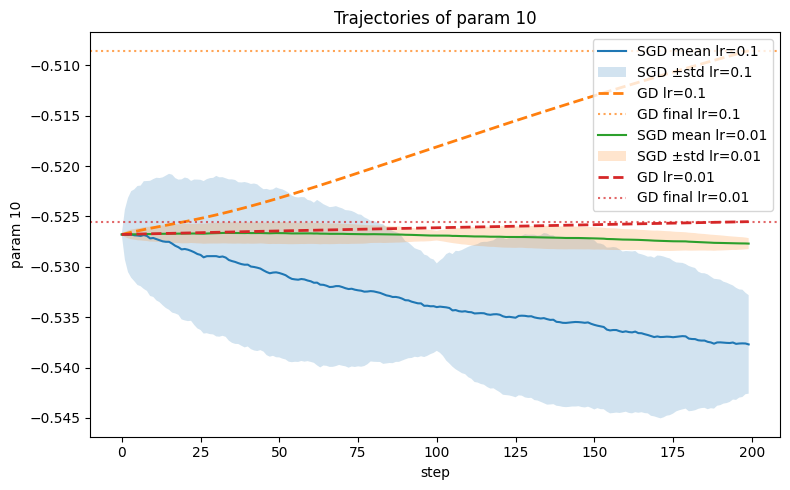

In [113]:
p = 10  # индекс параметра
plt.figure(figsize=(8, 5))

for i, lr in enumerate([float(x) for x in LRS_TO_USE]):
    # SGD: [N, T, D]
    trajs = W_SGD[i][:, :, p].numpy()[:,:200]  # shape [N, T]
    mean_traj = trajs.mean(axis=0)
    std_traj = trajs.std(axis=0)

    t_sgd = np.arange(trajs.shape[1])

    plt.plot(t_sgd, mean_traj, label=f"SGD mean lr={lr}")
    plt.fill_between(t_sgd,
                     mean_traj - std_traj,
                     mean_traj + std_traj,
                     alpha=0.2, label=f"SGD ±std lr={lr}")

    # GD: [T, D]
    traj_gd = W_GD[i][:, p].numpy()[:200]
    t_gd = np.arange(len(traj_gd))

    plt.plot(t_gd, traj_gd, '--', linewidth=2, label=f"GD lr={lr}")

    # горизонтальная линия по финальной точке GD
    final_val = traj_gd[-1]
    plt.axhline(final_val, linestyle=":", color=plt.gca().lines[-1].get_color(),
                alpha=0.7, label=f"GD final lr={lr}")

plt.xlabel("step")
plt.ylabel(f"param {p}")
plt.title(f"Trajectories of param {p}")
plt.legend()
plt.tight_layout()
plt.show()

In [72]:
import numpy as np
import matplotlib.pyplot as plt

num_p_arr = ind[[0,1,2,3,4,5 ,-5,-4-3, -2, -1]]

for num_p in num_p_arr:
    p_trajectories_sgd = W_SGD[:, :, num_p].numpy()  # shape: [n_trials, T]
    p_trajectories_gd = W_GD[:, num_p].numpy()    # shape: [1, T]

    # считаем среднее и std по траекториям SGD
    mean_sgd = np.mean(p_trajectories_sgd, axis=0)
    std_sgd = np.std(p_trajectories_sgd, axis=0)

    # график
    plt.figure(figsize=(6, 4))
    plt.plot(mean_sgd, label="SGD mean", color="blue")
    plt.fill_between(
        np.arange(len(mean_sgd)),
        mean_sgd - std_sgd,
        mean_sgd + std_sgd,
        color="blue",
        alpha=0.2,
        label="SGD ± std"
    )
    plt.plot(p_trajectories_gd, label="GD", color="red")
    plt.title(f"Parameter {num_p}")
    plt.legend()
    plt.show()


TypeError: list indices must be integers or slices, not tuple

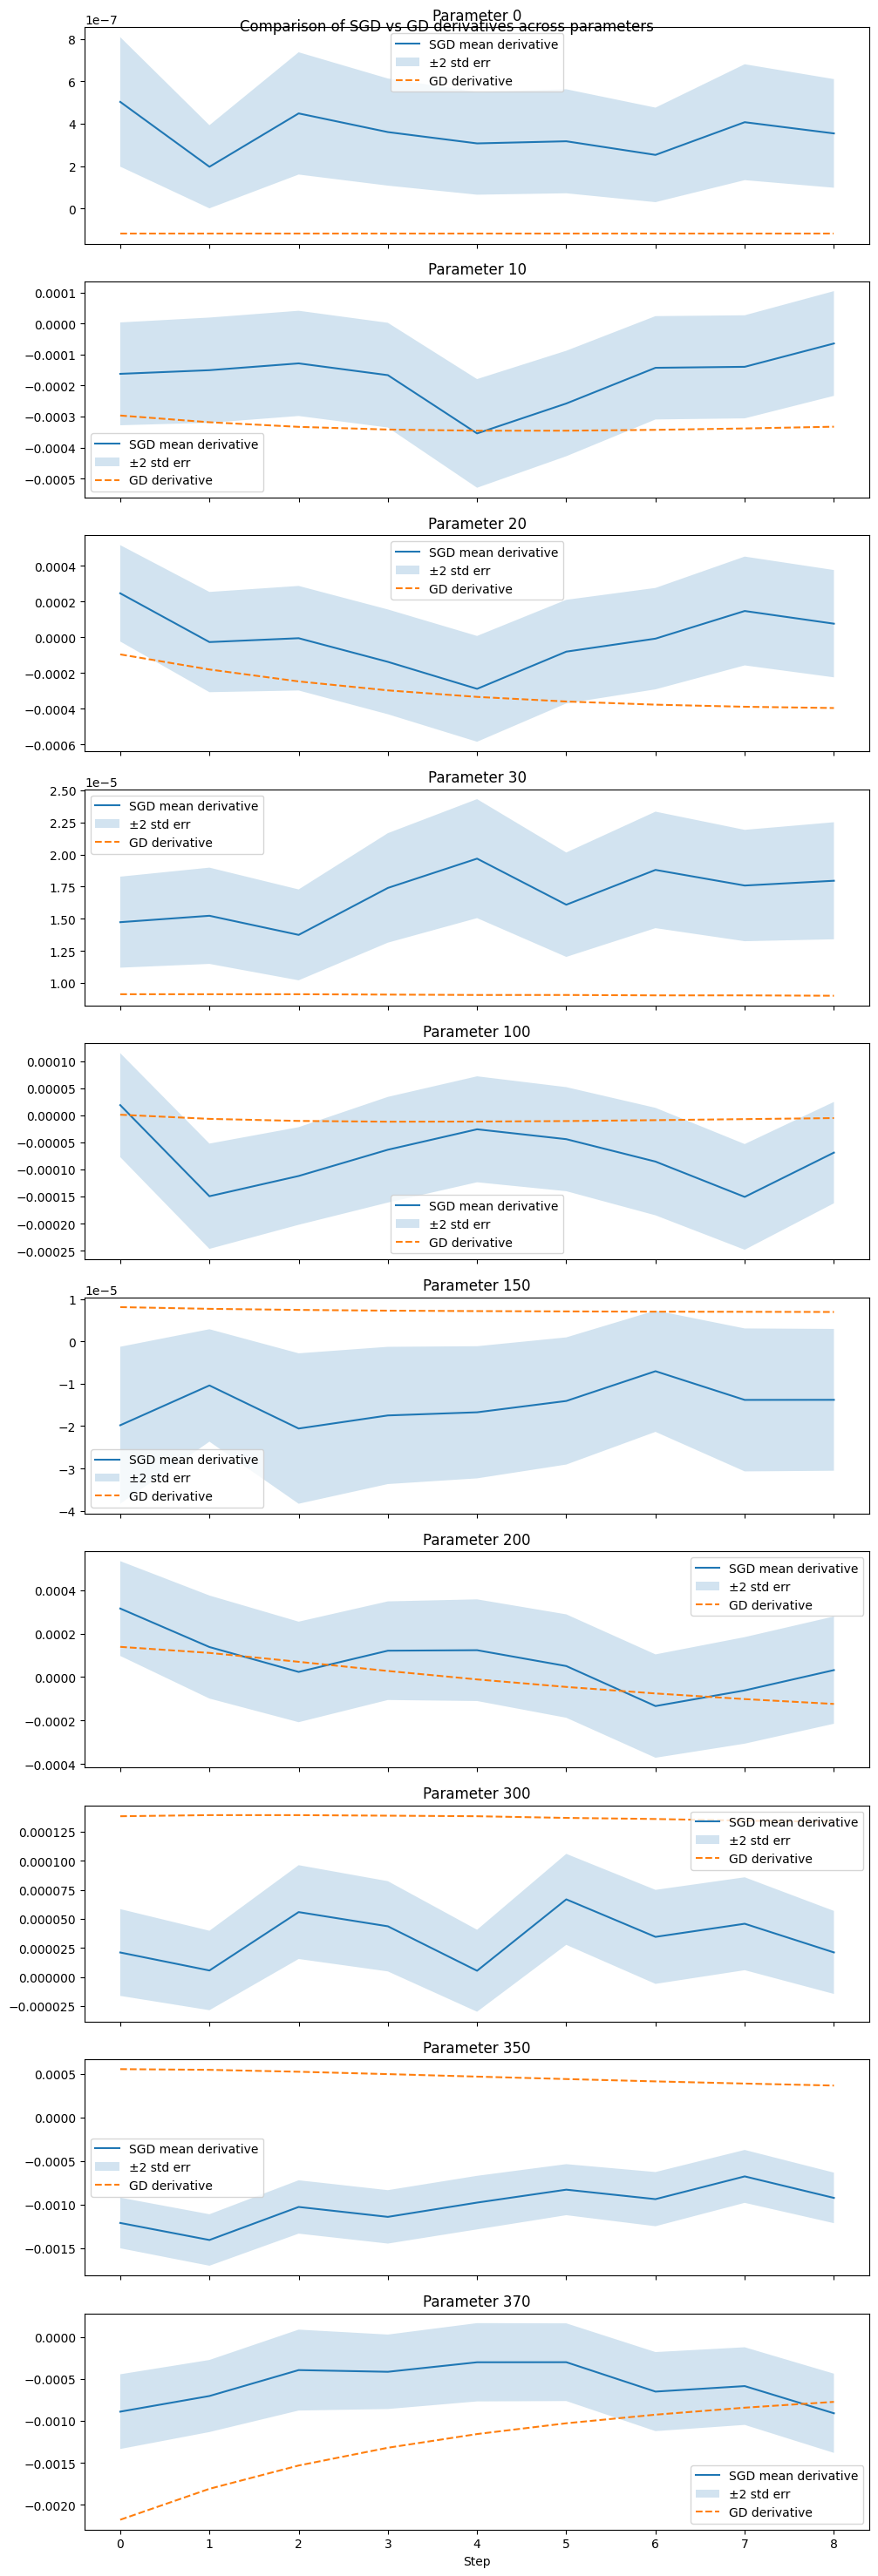

In [5]:
import numpy as np
import matplotlib.pyplot as plt

num_p_arr = [0, 10, 20, 30, 100, 150, 200, 300, 350, 370]

# Сколько шагов смотреть
max_steps = 10

fig, axes = plt.subplots(len(num_p_arr), 1, figsize=(10, 3 * len(num_p_arr)), sharex=True)

for idx, num_p in enumerate(num_p_arr):
    # --- Достаём траектории ---
    p_trajectories_sgd = W_SGD[:, :, num_p].numpy()  # [n_samples, n_steps]
    p_trajectories_gd = W_GD[ :, num_p].numpy()    # [1, n_steps]

    # --- Разности (производные по шагам) ---
    sgd_diff = p_trajectories_sgd[:, 1:max_steps] - p_trajectories_sgd[:, :max_steps-1]  # [n_samples, max_steps-1]
    gd_diff = p_trajectories_gd[1:max_steps] - p_trajectories_gd[:max_steps-1]     # [max_steps-1]

    # --- Усреднение и доверительный интервал ---
    sgd_mean = sgd_diff.mean(axis=0)
    sgd_std = sgd_diff.std(axis=0) / np.sqrt(sgd_diff.shape[0])  # ошибка среднего

    # --- Рисуем ---
    ax = axes[idx]
    ax.plot(sgd_mean, label="SGD mean derivative")
    ax.fill_between(np.arange(len(sgd_mean)), 
                    sgd_mean - 2*sgd_std, 
                    sgd_mean + 2*sgd_std, 
                    alpha=0.2, label="±2 std err")
    ax.plot(gd_diff, label="GD derivative", linestyle="--")
    ax.set_title(f"Parameter {num_p}")
    ax.legend()

plt.xlabel("Step")
plt.suptitle("Comparison of SGD vs GD derivatives across parameters")
plt.tight_layout()
plt.show()


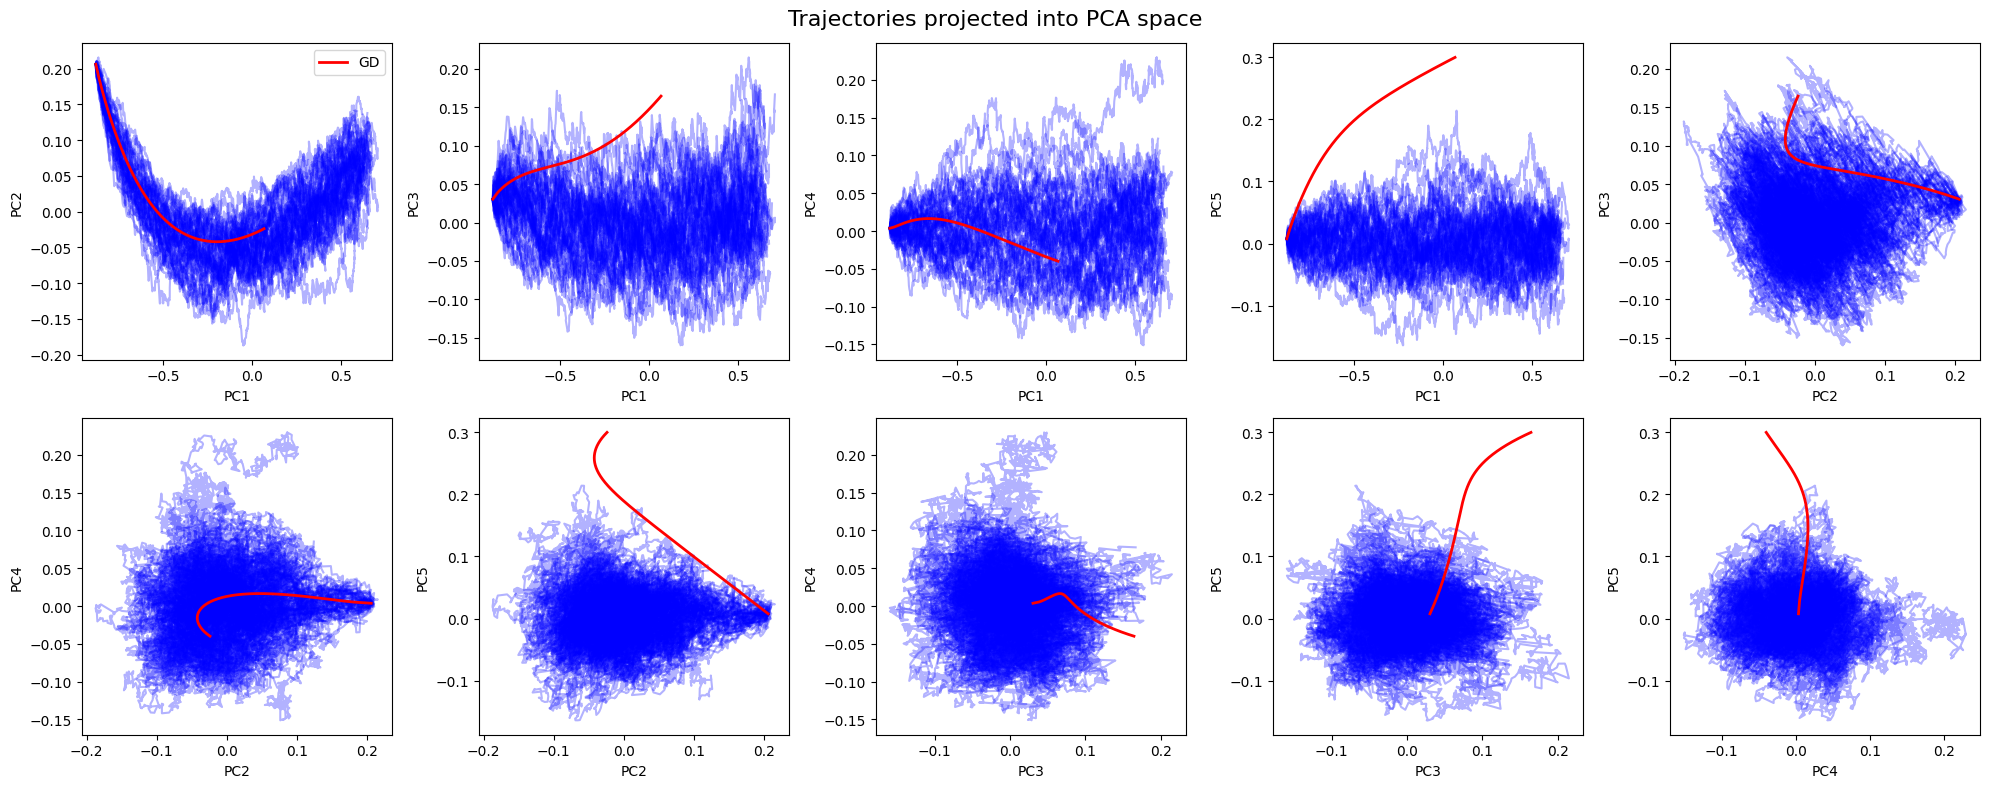

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# допустим W_SGD: [n_trials, T, d]
# допустим W_GD:  [1, T, d]

pairs = [(0,1), (0,2), (0,3), (0,4),
         (1,2), (1,3), (1,4),
         (2,3), (2,4),
         (3,4)]

# Берём все траектории SGD
n_trials, T, d = W_SGD.shape

# Для PCA склеиваем все траектории по времени и по траекториям
X = W_SGD.reshape(-1, d)  # [n_trials*T, d]

# Центрируем и делаем PCA
pca = PCA(n_components=5)
X_proj = pca.fit_transform(X)   # [n_trials*T, 5]

# Возвращаем в форму [n_trials, T, 5]
X_proj = X_proj.reshape(n_trials, T, -1)

# Теперь проекция GD
gd_proj = pca.transform(W_GD)   # [T, 5]

# --- Визуализация ---
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

for idx, (i, j) in enumerate(pairs):
    ax = axes[idx]
    # SGD trajectories
    for trial in range(min(50, n_trials)):   # рисуем не все, чтобы не захламлять
        ax.plot(X_proj[trial, :, i], X_proj[trial, :, j], alpha=0.3, color="blue")
    # GD trajectory
    ax.plot(gd_proj[:, i], gd_proj[:, j], color="red", linewidth=2, label="GD" if idx == 0 else "")
    ax.set_xlabel(f"PC{i+1}")
    ax.set_ylabel(f"PC{j+1}")
    if idx == 0:
        ax.legend()

fig.suptitle("Trajectories projected into PCA space", fontsize=16)
plt.tight_layout()
plt.show()


## STABILITY: different lr


In [74]:
import os
import torch

BASE_DIR = "./setup1"
# LRs_TO_USE = [
#     "0.1","0.05","0.01","0.005",
#     "0.001","0.0005","0.0001","5e-05","1e-05"
# ]

LRs_TO_USE = ["0.1", "0.01"]

W_array = []
for LR_TO_USE in LRs_TO_USE:
    PATH = os.path.join(BASE_DIR, f"gd_weights_lr{LR_TO_USE}_dtypefloat64.pt")
    # грузим как есть, без .float()
    W = torch.load(PATH, map_location="cpu")

    # если нужно гарантировать float64:
    # W = W.to(torch.float64)

    # ожидаем [N, T, D]
    print(PATH, W.shape, W.dtype)
    W_array.append(W)


./setup1/gd_weights_lr0.1_dtypefloat64.pt torch.Size([1111, 386]) torch.float64
./setup1/gd_weights_lr0.01_dtypefloat64.pt torch.Size([1111, 386]) torch.float64


In [75]:
W_array[0][0][0].dtype


torch.float64

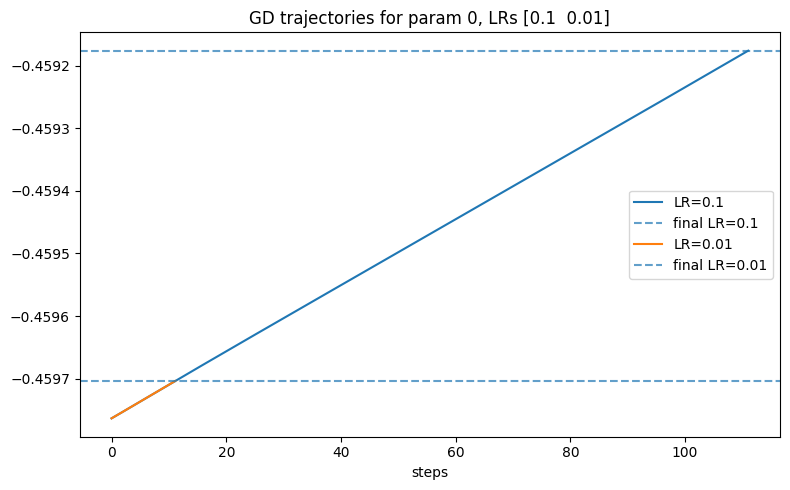

In [77]:
import numpy as np
import matplotlib.pyplot as plt

params = [0]

lrs = np.array([float(lr) for lr in LRs_TO_USE])

# идём по парам соседних lr
for i in range(len(lrs) - 1):
    curr_lrs = lrs[i:i+2]
    curr_W = W_array[i:i+2]

    for p in params:
        plt.figure(figsize=(8, 5))

        for lr, W in zip(curr_lrs, curr_W):
            traj = W[:, p].numpy()   # сама траектория параметра
            # рисуем траекторию

            plt.plot( lr * np.arange(len(traj)), traj, label=f"LR={lr}")

            # горизонтальная линия по конечной точке
            final_val = traj[-1]
            plt.axhline(final_val, linestyle="--", alpha=0.7, label=f"final LR={lr}")

        plt.legend()
        plt.xlabel("steps")
        plt.title(f"GD trajectories for param {p}, LRs {curr_lrs}")
        plt.tight_layout()
        plt.show()
